<a href="https://colab.research.google.com/github/CosmoStat/jax-lensing/blob/paper-nb/papers/Remy2021/SpectralNormRegularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impact of Spectral Normalization on the score function

Authors:
- [@b-remy](https://github.com/b-remy) (Benjamin Remy)
- [@EiffL](https://github.com/EiffL) (Francois Lanusse)

## Overview

This notebook presents an illustration of the spectral normalization influence on the score function regularity as used in Remy et al. 2021 (in prep.)



In [1]:
!pip install dm-haiku --quiet
!pip install optax --quiet

In [2]:
%pylab inline

from functools import partial

import jax
import jax.numpy as jnp
import numpy as onp

import haiku as hk
import optax

import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfd = tfp.distributions

Populating the interactive namespace from numpy and matplotlib


##Creating a test density

For the purpose of this notebook, our test density is going to be the swiss roll distribution.

In [3]:
#@title [Run me]
from sklearn.datasets import make_swiss_roll
def get_swiss_roll(sigma, resolution=1024):

  n_samples = 2*resolution
  X, _ = make_swiss_roll(n_samples, noise=0)
  coords = np.vstack([X[:, 0], X[:, 2]])

  distribution = tfd.MixtureSameFamily(
  mixture_distribution=tfd.Categorical(probs=np.ones(2*resolution)/resolution/2),
  components_distribution=tfd.MultivariateNormalDiag(loc=coords.T, scale_identity_multiplier=sigma)
  )
  return distribution

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5792: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3026: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")


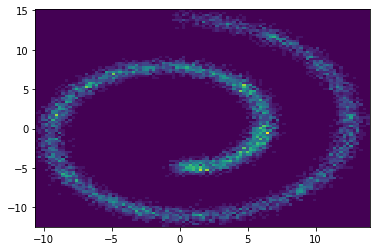

In [4]:
dist = get_swiss_roll(0.5)

rng_key = jax.random.PRNGKey(seed=0)
samps = dist.sample(10000, seed=rng_key)

# Plotting samples
hist2d(samps[:,0], samps[:,1],100);

Create a simple autoencoder model in haiku that will be used to evaluate the score function.

In [5]:
class ARDAE(hk.Module):
  def __init__(self, is_training=False):
    super(ARDAE, self).__init__()
    self.is_training=is_training

  def __call__(self, x, sigma):
    sigma = sigma.reshape((-1,1))
    # Encoder
    net = hk.Linear(128)(jnp.concatenate([x, sigma],axis=1))
    net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(128)(net)
    net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(2)(net)

    # Decoder
    net = hk.Linear(128)(jnp.concatenate([net, sigma],axis=1))
    net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(128)(net)
    net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(2)(net)

    return net

In [ ]:
batch_size = 512
delta = 0.5

def get_batch(rng_key):
    y = two_moons.sample(batch_size, seed=rng_key)
    u = onp.random.randn(batch_size, 2)
    s = delta * onp.random.randn(batch_size, 1)
    x = y + s * u
    # x is a noisy sample, y is a sample from the distribution
    # u is the random normal noise realisation
    return {'x':x, 'y':y, 'u':u, 's':s}

In [6]:
def forward(x, sigma, is_training=False):
    denoiser = ARDAE(is_training=is_training)
    return denoiser(x, sigma)

model_train = hk.transform_with_state(partial(forward, is_training=True))

In [8]:
optimizer = optax.adam(1e-3)
rng_seq = hk.PRNGSequence(42)

In [9]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
  res, state = model_train.apply(params,  state, rng_key, 
                                  batch['x'], batch['s'])
  loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
  return loss, state

In [10]:
@jax.jit
def update(params, state, rng_key, opt_state, batch):
  (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return loss, new_params, state, new_opt_state

In [11]:
params, state = model_train.init(next(rng_seq), 
                                 jnp.zeros((1, 2)), 
                                 jnp.ones((1, 1)))
opt_state = optimizer.init(params)
losses = []

In [12]:
for step in range(10000):
  batch = get_batch(next(rng_seq))
  loss, params, state, opt_state = update(params, state, next(rng_seq), opt_state, batch)
  losses.append(loss)
  if step%100==0:
    print(step, loss)

0 1.351959
100 0.9441461
200 0.9397932
300 0.8743969
400 0.89548886
500 0.9696569
600 0.84195846
700 0.8851192
800 0.9301207
900 0.83904624
1000 0.87487805
1100 0.8893932
1200 0.8476459
1300 0.94344723
1400 0.8584977
1500 0.7787711
1600 0.8755778
1700 0.8875239
1800 0.8027481
1900 0.86235046
2000 0.93913066
2100 1.0241212
2200 0.8465358
2300 0.9586239
2400 0.9350257
2500 0.92581254
2600 0.86061066
2700 0.86762613
2800 0.890148
2900 0.8881066
3000 0.84045905
3100 0.81331074
3200 0.88850534
3300 0.93198806
3400 0.83091474
3500 0.86985916
3600 0.89675
3700 0.92327905
3800 0.9079819
3900 0.9740715
4000 0.9213426
4100 0.8975978
4200 0.8359512
4300 0.8940111
4400 0.8724081
4500 0.8094197
4600 0.9202486
4700 0.8522936
4800 0.9212989
4900 0.8159325
5000 0.83788407
5100 0.89627695
5200 0.8338434
5300 0.8720119
5400 0.9044243
5500 0.87989676
5600 0.88390285
5700 0.9307127
5800 0.8810499
5900 0.9466063
6000 0.8566627
6100 0.81772876
6200 0.8819258
6300 0.91631925
6400 0.87634534
6500 0.8267222
66

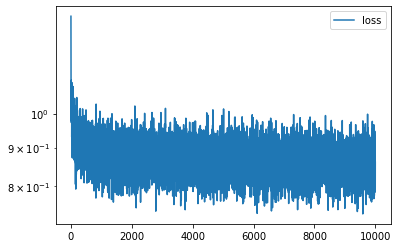

In [13]:
semilogy(np.array(losses[:]), label='loss')
legend()

In [14]:
model = hk.transform_with_state(partial(forward, is_training=False))
dae_score = partial(model.apply, params, state, next(rng_seq))

We display the score function vector field over the distribution density:

In [38]:
#@title [Run me]
def display_score_swiss_roll(score, distribution, dpi=100, n=24, is_amortized=True, is_reg=True):
  N = 128
  xc,yc = jnp.meshgrid(jnp.linspace(-20,20,N),jnp.linspace(-20,20,N))
  Z = jnp.stack([xc.flatten(), yc.flatten()],axis=1).astype('float32')
  S = distribution.log_prob(Z)
  plt.figure(figsize=[5,5], dpi=dpi)
  plt.imshow(jnp.exp(S.reshape((N,N))), cmap='Blues', origin='lower')

  X = jnp.linspace(-20, 20, n)
  Y = jnp.linspace(-20., 20, n)

  points = jnp.stack(jnp.meshgrid(X, Y), axis=-1).reshape((-1, 2))

  if is_amortized:
    if is_reg:
      res, state = score(points, 0.0*jnp.ones((len(points),1)))
    else:
      res = score(points, 0.0*jnp.ones((len(points),1)))
  else:
    if is_reg:
      res, state = score(points)
    else:
      res = score(points)

  g = res.reshape([n, n, 2])

  #print(g.shape)
  #g = score(points).reshape([len(Y), len(X), 2])
  _x = jnp.linspace(0, N, n)
  _y = jnp.linspace(0, N, n)
  plt.quiver(_x, _y, g[:,:,0], g[:,:,1])
  plt.axis('equal')
  plt.axis('off')



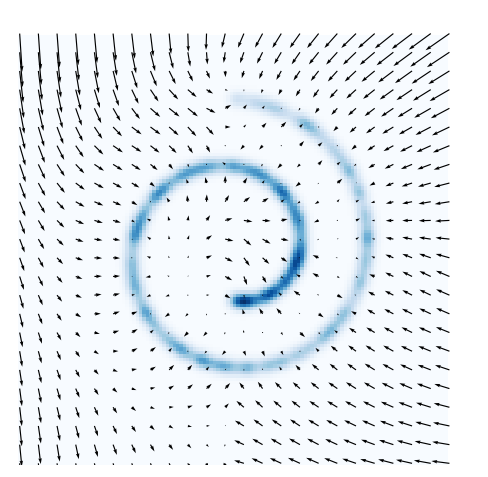

In [45]:
display_score_swiss_roll(dae_score, dist, is_amortized=True, is_reg=True, dpi=120)
savefig('no-sn.png')

We can observe regions where the score function does not point towards the high density regions of the distribution. These regions will be problematic for sampling.

To solve this, let's impose some regularity by regularizing the spectral norm of the weights.

## With Spectral Norm Regularisation

In [17]:
#@title Import haiku Spectral Normalization [Run me]
# Copyright 2019 DeepMind Technologies Limited. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Spectral Normalization tools.
This implementation follows the use in:
  https://arxiv.org/abs/1802.05957
  https://arxiv.org/abs/1805.08318
  https://arxiv.org/abs/1809.11096
"""

import re
import types
from typing import Optional

from haiku._src import base
from haiku._src import data_structures
from haiku._src import initializers
from haiku._src import module
import jax
import jax.lax
import jax.numpy as jnp

import haiku as hk


def _l2_normalize(x, axis=None, eps=1e-12):
  """Normalizes along dimension `axis` using an L2 norm.
  This specialized function exists for numerical stability reasons.
  Args:
    x: An input ndarray.
    axis: Dimension along which to normalize, e.g. `1` to separately normalize
      vectors in a batch. Passing `None` views `t` as a flattened vector when
      calculating the norm (equivalent to Frobenius norm).
    eps: Epsilon to avoid dividing by zero.
  Returns:
    An array of the same shape as 'x' L2-normalized along 'axis'.
  """
  return x * jax.lax.rsqrt((x * x).sum(axis=axis, keepdims=True) + eps)


class SpectralNorm(hk.Module):
  """Normalizes an input by its first singular value.
  This module uses power iteration to calculate this value based on the
  input and an internal hidden state.
  """

  def __init__(
      self,
      eps: float = 1e-4,
      n_steps: int = 1,
      val: float = 2,
      name: Optional[str] = None,
  ):
    """Initializes an SpectralNorm module.
    Args:
      eps: The constant used for numerical stability.
      n_steps: How many steps of power iteration to perform to approximate the
        singular value of the input.
      name: The name of the module.
    """
    super().__init__(name=name)
    self.eps = eps
    self.n_steps = n_steps
    self.val = val

  def __call__(
      self,
      value,
      update_stats: bool = True,
      error_on_non_matrix: bool = False,
  ) -> jnp.ndarray:
    """Performs Spectral Normalization and returns the new value.
    Args:
      value: The array-like object for which you would like to perform an
        spectral normalization on.
      update_stats: A boolean defaulting to True. Regardless of this arg, this
        function will return the normalized input. When
        `update_stats` is True, the internal state of this object will also be
        updated to reflect the input value. When `update_stats` is False the
        internal stats will remain unchanged.
      error_on_non_matrix: Spectral normalization is only defined on matrices.
        By default, this module will return scalars unchanged and flatten
        higher-order tensors in their leading dimensions. Setting this flag to
        True will instead throw errors in those cases.
    Returns:
      The input value normalized by it's first singular value.
    Raises:
      ValueError: If `error_on_non_matrix` is True and `value` has ndims > 2.
    """
    value = jnp.asarray(value)
    value_shape = value.shape

    # Handle scalars.
    if value.ndim <= 1:
      raise ValueError("Spectral normalization is not well defined for "
                       "scalar or vector inputs.")
    # Handle higher-order tensors.
    elif value.ndim > 2:
      if error_on_non_matrix:
        raise ValueError(
            f"Input is {value.ndim}D but error_on_non_matrix is True")
      else:
        value = jnp.reshape(value, [-1, value.shape[-1]])

    u0 = hk.get_state("u0", [1, value.shape[-1]], value.dtype,
                      init=hk.initializers.RandomNormal())

    # Power iteration for the weight's singular value.
    for _ in range(self.n_steps):
      v0 = _l2_normalize(jnp.matmul(u0, value.transpose([1, 0])), eps=self.eps)
      u0 = _l2_normalize(jnp.matmul(v0, value), eps=self.eps)

    u0 = jax.lax.stop_gradient(u0)
    v0 = jax.lax.stop_gradient(v0)

    sigma = jnp.matmul(jnp.matmul(v0, value), jnp.transpose(u0))[0, 0]

    value /= sigma
    value *= self.val
    value_bar = value.reshape(value_shape)

    if update_stats:
      hk.set_state("u0", u0)
      hk.set_state("sigma", sigma)

    return value_bar

  @property
  def u0(self):
    return hk.get_state("u0")

  @property
  def sigma(self):
    return hk.get_state("sigma", shape=(), init=jnp.ones)


class SNParamsTree(hk.Module):
  """Applies Spectral Normalization to all parameters in a tree.
  This is isomorphic to EMAParamsTree in moving_averages.py.
  """

  def __init__(
      self,
      eps: float = 1e-4,
      n_steps: int = 1,
      ignore_regex: str = "",
      val: float = 2,
      name: Optional[str] = None,
  ):
    """Initializes an SNParamsTree module.
    Args:
      eps: The constant used for numerical stability.
      n_steps: How many steps of power iteration to perform to approximate the
        singular value of the input.
      ignore_regex: A string. Any parameter in the tree whose name matches this
        regex will not have spectral normalization applied to it. The empty
        string means this module apply to all parameters.
      name: The name of the module.
    """
    super().__init__(name=name)
    self.eps = eps
    self.n_steps = n_steps
    self.ignore_regex = ignore_regex
    self.val = val

  def __call__(self, tree, update_stats=True):
    def maybe_sn(k, v):
      if self.ignore_regex and re.match(self.ignore_regex, k):
        return v
      else:
        sn_name = k.replace("/", "__").replace("~", "_tilde")
        return SpectralNorm(self.eps, self.n_steps, val=self.val, name=sn_name)(
            v, update_stats=update_stats)

    # We want to potentially replace params with Spectral Normalized versions.
    new_values = {}
    for module_name, param_dict in tree.items():
      new_values[module_name] = {
          k: maybe_sn("/".join([module_name, k]), v)
          for k, v in param_dict.items()
      }
    return hk.data_structures.to_immutable_dict(new_values)

In [18]:
def forward(x, sigma, is_training=False):
  denoiser = ARDAE(is_training=is_training)
  return denoiser(x, sigma)

model_train = hk.transform_with_state(partial(forward, is_training=True))

sn_fn = hk.transform_with_state(lambda x: SNParamsTree(ignore_regex='[^?!.]*b$', val=1)(x))

In [19]:
optimizer = optax.adam(1e-3)
rng_seq = hk.PRNGSequence(42)

In [20]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
  res, state = model_train.apply(params,  state, rng_key, 
                                  batch['x'], batch['s'])
  loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
  return loss, state

In [21]:
@jax.jit
def update(params, state, sn_state, rng_key, opt_state, batch):
  (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  
  new_params, new_sn_state = sn_fn.apply(None, sn_state, None, new_params)
  
  return loss, new_params, state, new_sn_state, new_opt_state

In [22]:
params, state = model_train.init(next(rng_seq), 
                                 jnp.zeros((1, 2)), 
                                 jnp.ones((1, 1)))
opt_state = optimizer.init(params)
_, sn_state = sn_fn.init(jax.random.PRNGKey(1), params)

losses = []

In [23]:
for step in range(10000):
  batch = get_batch(next(rng_seq))
  loss, params, state, sn_state, opt_state = update(params, state, sn_state, next(rng_seq), opt_state, batch)
  losses.append(loss)
  if step%100==0:
    print(step, loss)

0 1.4152583
100 0.98930025
200 1.0497999
300 0.884354
400 0.8639349
500 0.9350264
600 0.84701324
700 0.9348866
800 0.9513484
900 0.8268494
1000 0.8450078
1100 0.9134307
1200 0.8663142
1300 0.95667684
1400 0.816109
1500 0.9137775
1600 0.90751
1700 0.9706882
1800 0.9230444
1900 0.8775135
2000 0.91126585
2100 0.8972427
2200 0.93852943
2300 0.9236076
2400 0.8559375
2500 0.8587387
2600 0.8722755
2700 0.936153
2800 0.8585057
2900 0.8572725
3000 0.8583778
3100 0.817654
3200 0.85604966
3300 0.8670901
3400 0.8375373
3500 0.8547981
3600 0.86965275
3700 0.8603067
3800 0.92030513
3900 0.9732398
4000 0.8941108
4100 0.8861824
4200 0.9277959
4300 0.80943686
4400 0.9384713
4500 0.9263325
4600 0.9397721
4700 0.9336591
4800 0.7890589
4900 0.85578763
5000 0.86229
5100 0.89536196
5200 0.85991675
5300 0.88691473
5400 0.8860567
5500 0.90891516
5600 0.84435177
5700 0.90672594
5800 0.9052354
5900 0.8430172
6000 0.89738786
6100 0.9531028
6200 0.840626
6300 0.8705017
6400 0.8900628
6500 0.88187706
6600 0.842056

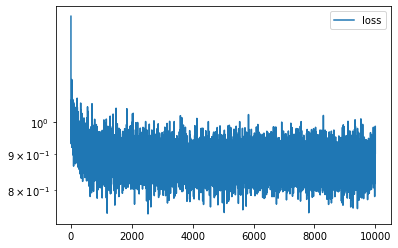

In [24]:
semilogy(np.array(losses[:]), label='loss')
legend()

In [25]:
model_sn = hk.transform_with_state(partial(forward, is_training=False))
score_sn = partial(model_sn.apply, params, state, next(rng_seq))

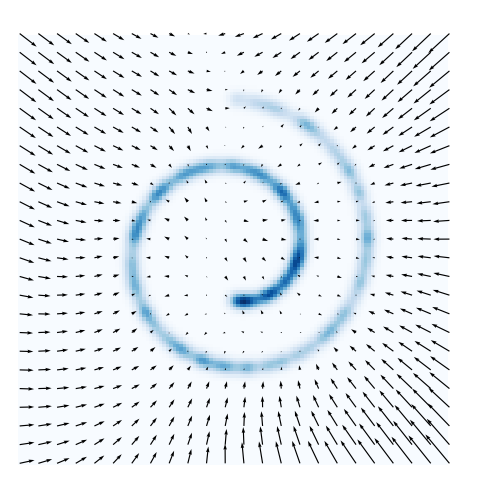

In [43]:
display_score_swiss_roll(score_sn, dist, is_amortized=True, is_reg=True, dpi=120)
savefig('sn1.png')

The score function is now pointing towards high density regions of the distribution from every where !